# Hockey Analytics

## Question:
Which teams give the most ice time to their top line?

## Order of Execution:

1) Get a table consisting of team_id, team_name, and team_api_link 

2) Find all available Forward players from the above teams

3) Scrape timeOnIce for each players on each teams on different leagues

In [14]:
import pandas as pd
import requests
import random

### Step 1: Get a table consisting of team_id, team_name, and team_api_link 

In [6]:
team_url = 'https://statsapi.web.nhl.com/api/v1/teams/'
team = requests.get(team_url)
team = team.json()['teams']
team = pd.DataFrame(team)
team = team[['id','name','link']]
team.sample(10)

,id,name,link
18,20,Calgary Flames,/api/v1/teams/20
14,16,Chicago Blackhawks,/api/v1/teams/16
29,53,Arizona Coyotes,/api/v1/teams/53
24,26,Los Angeles Kings,/api/v1/teams/26
22,24,Anaheim Ducks,/api/v1/teams/24
30,54,Vegas Golden Knights,/api/v1/teams/54
20,22,Edmonton Oilers,/api/v1/teams/22
3,4,Philadelphia Flyers,/api/v1/teams/4
21,23,Vancouver Canucks,/api/v1/teams/23
5,6,Boston Bruins,/api/v1/teams/6


### Step 2: Find all available Forward players from the above teams

In [23]:
roster_list = []
for i in team['id']:
    team_roster = requests.get(f'https://statsapi.web.nhl.com/api/v1/teams/{i}/roster')
    team_roster = team_roster.json()['roster']
    for l in range(len(team_roster)):
        if team_roster[l]['position']['type'] == 'Forward':
            roster_list.append(team_roster[l]['person']['id'])
            
#Remove potential duplicate in case of duplicate player_id
roster_list = list(set(roster_list))

print('Length of roster_list: ', len(roster_list))

Length of roster_list:  473


#### Hygiene check roster_list

In [27]:
check_roster = requests.get(f'https://statsapi.web.nhl.com/api/v1/people/{random.choice(roster_list)}')
print('Player ID: ',check_roster.json()['people'][0]['id'])
print('Team: ',check_roster.json()['people'][0]['currentTeam']['name'])
print('Primary Position: ',check_roster.json()['people'][0]['primaryPosition']['type'])

Player ID:  8478874
Team:  Ottawa Senators
Primary Position:  Forward


### Step 3: Scrape timeOnIce for each players on each teams

#### Note:
Since players can switch team mid-season and one player can play in multiple leagues (Some of which do not have timeOnIce data), we can expect to obtain multiple timeOnIce records for some players

In [29]:
#For records where timeOnIce is available
available_player_data = [] #player_id
available_team_list = [] #team name
available_timeOnIce = [] 
available_season = [] 
available_league = []

#For records where timeOnIce is not available
missing_player_data = [] #player_id
missing_team_list = [] #team name
missing_timeOnIce = []
missing_season = []
missing_league = []

for r in roster_list:
    forward_record = requests.get(f'https://statsapi.web.nhl.com/api/v1/people/{r}/stats?stats=yearByYear')
    forward_record = forward_record.json()['stats'][0]['splits']
    for l in range(len(forward_record)):
        if forward_record[l]['season'] == '20202021' or forward_record[l]['season'] == '20212022':
            try:
                time = forward_record[l]['stat']['timeOnIce'] #Format Example: '823:38'
                time = time.split(':') #['823', '38']
                time = [int(i) for i in time] #[823,38]
                time[0] = time[0] + time[1]/60 #[823.6333, 38]
                time.pop() #[823.6333]
                
                available_player_data.append(r)
                available_team_list.append(forward_record[l]['team']['name'])
                available_timeOnIce.append(time[0])
                available_season.append(forward_record[l]['season'])
                available_league.append(forward_record[l]['league']['name'])
                
            except:
                missing_player_data.append(r)
                missing_team_list.append(forward_record[l]['team']['name'])
                missing_timeOnIce.append(0)
                missing_season.append(forward_record[l]['season'])
                missing_league.append(forward_record[l]['league']['name'])

#### Note: Segment these two scenarios into 2 dataframes for checking purposes

In [30]:
available_ice_data = pd.DataFrame({
    'people_id': available_player_data,
    'team': available_team_list,
    'timeOnIce': available_timeOnIce,
    'season': available_season,
    'league': available_league
     })

missing_ice_data = pd.DataFrame({
    'people_id': missing_player_data,
    'team': missing_team_list,
    'timeOnIce': missing_timeOnIce,
    'season': missing_season,
    'league': missing_league
     })

Safety check 1: https://statsapi.web.nhl.com/api/v1/people/8474641/stats?stats=yearByYear

Safety check 2: https://statsapi.web.nhl.com/api/v1/people/8480789/stats?stats=yearByYear

In [31]:
available_ice_data.head(10)

,people_id,team,timeOnIce,season,league
0,8474641,Anaheim Ducks,721.800000,20202021,National Hockey League
1,8474641,Anaheim Ducks,404.950000,20212022,National Hockey League
2,8480789,New York Islanders,544.983333,20202021,National Hockey League
3,8480789,New York Islanders,343.916667,20212022,National Hockey League
4,8480797,Philadelphia Flyers,881.000000,20202021,National Hockey League
5,8480797,Philadelphia Flyers,446.216667,20212022,National Hockey League
6,8480798,Chicago Blackhawks,706.216667,20202021,National Hockey League
7,8480798,Chicago Blackhawks,372.933333,20212022,National Hockey League
8,8480801,Ottawa Senators,1020.866667,20202021,National Hockey League
9,8480801,Ottawa Senators,475.866667,20212022,National Hockey League


In [32]:
missing_ice_data.head(10)

,people_id,team,timeOnIce,season,league
0,8480789,AIK,0,20202021,HockeyAllsvenskan
1,8480798,Lugano,0,20202021,NL
2,8480798,Switzerland,0,20202021,WC
3,8480798,Rockford IceHogs,0,20212022,AHL
4,8480802,Zug,0,20202021,NL
5,8480802,Bakersfield Condors,0,20202021,AHL
6,8480802,Bakersfield Condors,0,20212022,AHL
7,8480806,Timrå IK,0,20202021,HockeyAllsvenskan
8,8480806,Sweden,0,20202021,WC
9,8480813,Malmö Redhawks,0,20202021,SHL


### Solution to original question:

In [44]:
sum_ice_data = available_ice_data.groupby('team')['timeOnIce'].sum().to_frame(name = 'total_ice_time').reset_index()
sum_ice_data.sample(10)

,team,total_ice_time
18,New York Islanders,13954.383333
29,Vegas Golden Knights,15398.333333
21,Philadelphia Flyers,15815.450000
17,New Jersey Devils,11860.766667
14,Minnesota Wild,14526.866667
15,Montréal Canadiens,15830.450000
5,Carolina Hurricanes,15336.333333
13,Los Angeles Kings,11742.350000
6,Chicago Blackhawks,15498.666667
20,Ottawa Senators,14524.600000


In [45]:
sum_ice_data[sum_ice_data.total_ice_time == sum_ice_data.total_ice_time.max()]

,team,total_ice_time
31,Winnipeg Jets,16141.866667


### Answer: Winnipeg Jets

### Interpretations:

#### Approaches:
1) Team Standings

2) Team Stats

### Based on Total Ice Time by Team and Season

In [70]:
ice_data_stats = available_ice_data.groupby(['team','season']).agg({'timeOnIce': ['mean', 'min', 'max', 'sum','count']})
ice_data_stats.columns = ['ice_mean','ice_min', 'ice_max', 'ice_sum','count_of_players']
ice_data_stats = ice_data_stats.reset_index()
top_5 = sum_ice_data.nlargest(5,'total_ice_time')['team'].tolist()
ice_data_stats.loc[ice_data_stats['team'].isin(top_5)]

,team,season,ice_mean,ice_min,ice_max,ice_sum,count_of_players
24,Florida Panthers,20202021,599.871875,88.533333,1046.866667,9597.950000,16
25,Florida Panthers,20212022,405.628889,168.800000,657.550000,6084.433333,15
30,Montréal Canadiens,20202021,607.208333,11.383333,1018.166667,9715.333333,16
31,Montréal Canadiens,20212022,265.874638,8.400000,684.416667,6115.116667,23
42,Philadelphia Flyers,20202021,649.665556,20.466667,977.700000,9744.983333,15
43,Philadelphia Flyers,20212022,337.248148,20.566667,591.200000,6070.466667,18
51,Tampa Bay Lightning,20202021,738.429487,66.283333,1032.416667,9599.583333,13
52,Tampa Bay Lightning,20212022,450.133333,79.483333,694.883333,6301.866667,14
61,Winnipeg Jets,20202021,598.178431,16.333333,1173.900000,10169.033333,17
62,Winnipeg Jets,20212022,351.343137,4.933333,701.050000,5972.833333,17


### Comments:
* Winnipeg Jets gave the most ice time to their top line in 2020-2021 seasons (but there is no guarantee they would achieve the same status once 2021-2022 season closes.)
* These teams are categorized in different divisions. Their approaches to the games can vary accordingly (More focus on top line vs focus on second/third/fourth line) division by division

## Question: 
* Designing an NHL Data Pipelin
* The prompt: The Boston Bruins want to be able to run custom stat queries against NHL data.

Describe how you would build an automated pipeline to ETL NHL play-by-play data into an internal database. This (hypothetical) internal database should have a central “nhl_events” table where each event is recorded as a row. The database can optionally have any other tables you would like to add.

## Approaches:

* Tool: Selenium Webdriver, Airflow, PostgreSQL, Redshift
* Main Source: https://www.nhl.com/scores/

## Order of Execution:
Image Link: https://drive.google.com/file/d/1F8dPIob06nPygO7MzeqQ8KtQtymZjGpU/view?usp=sharing

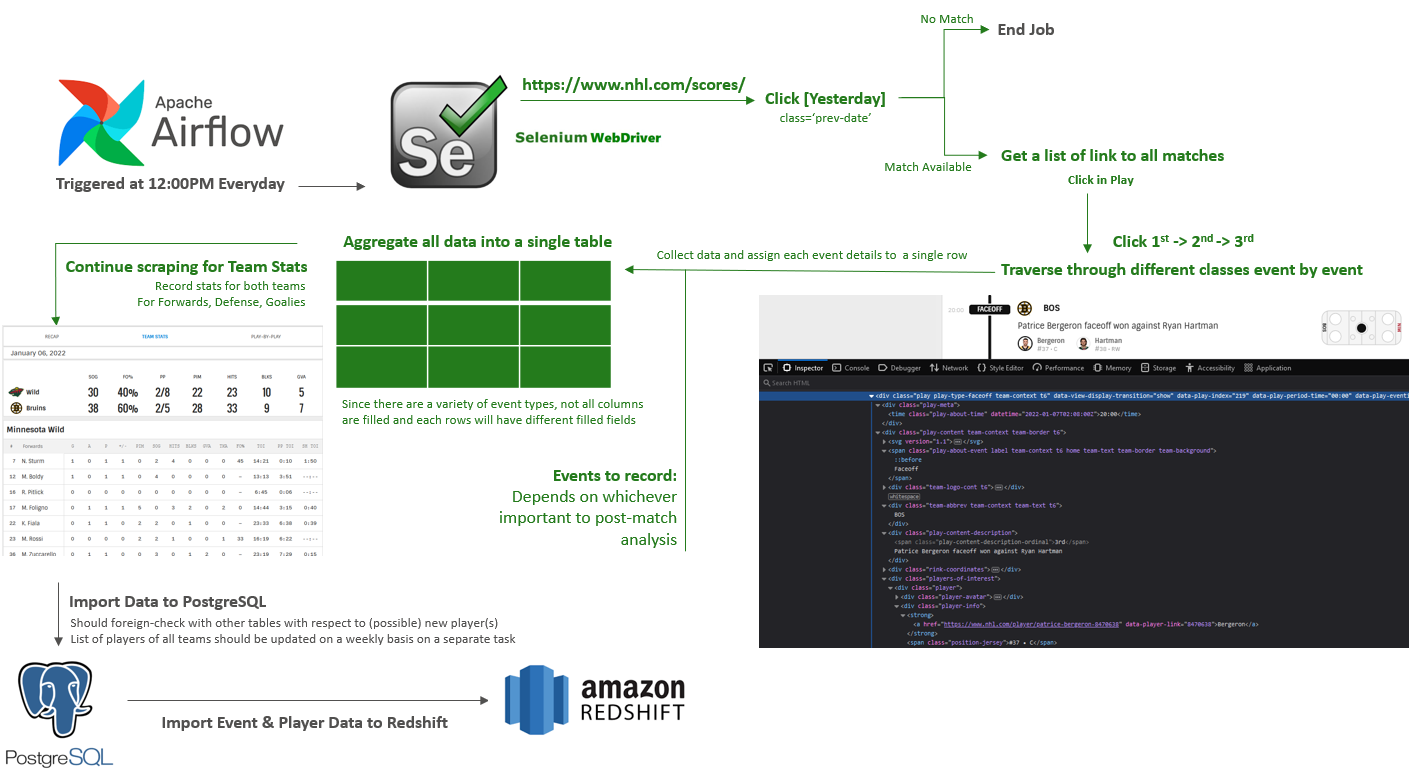